In [36]:
!pip install prophet==1.1.1

'pip' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
import prophet
import holidays

print("Prophet version:", prophet.__version__)
print("Holidays version:", holidays.__version__)


Prophet version: 1.1.6
Holidays version: 0.58


In [38]:
from prophet import Prophet
import numpy as np

class MyProphet:

    def __init__(self, args):
        self.response_col = args.response_col
        self.date_col = args.date_col

    def fit(self, data_x):
        self.model_fbp = Prophet()
        self.regressors = []
        for col in data_x.columns:
            if col != self.response_col and col != self.date_col:
                self.regressors.append(col)
        for feature in self.regressors:
            self.model_fbp.add_regressor(feature)
        data_x[self.regressors] = data_x[self.regressors].astype(float)
        data_x[self.response_col] = data_x[self.response_col].astype(float)
        ml_df1 = data_x.reset_index().rename(columns={self.date_col: 'ds', self.response_col: 'y'})
        # print(train_x)
        self.model_fbp.fit(ml_df1)

    def predict(self, test_x):
        # Upewnij się, że wszystkie regresory są typu float
        for reg in self.regressors:
            test_x[reg] = test_x[reg].astype(float)
        
        # Zmień nazwę kolumny daty na 'ds'
        test_x = test_x.rename(columns={self.date_col: 'ds'})
        
        # Prophet nie potrzebuje kolumny 'y' w danych do prognozy
        # Usuń kolumnę 'y' jeśli istnieje
        if 'y' in test_x.columns:
            test_x = test_x.drop(columns=['y'])
        
        # Upewnij się, że kolumna 'ds' jest typu datetime
        test_x['ds'] = pd.to_datetime(test_x['ds'])
        
        # Dokonaj prognozy
        pred_y = self.model_fbp.predict(test_x)
        return pred_y['yhat']


In [39]:
import yfinance as yf
import pandas as pd

# Pobierz dane historyczne dla wybranego tickera, np. Apple (AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Wyświetl pierwsze kilka wierszy
print(data.head())


[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876114  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167603  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742668  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565201  132079200


In [40]:
# Resetuj indeks, aby data była kolumną
data = data.reset_index()

# Tworzymy kolumnę 'Next_Close', przesuwając kolumnę 'Close' o jeden dzień w górę
data['Next_Close'] = data['Close'].shift(-1)

# Usuwamy ostatni wiersz, ponieważ nie ma dla niego 'Next_Close'
data = data[:-1]

# Wybieramy potrzebne kolumny
data = data[['Date', 'Open', 'High', 'Low', 'Volume', 'Next_Close']]

# Wyświetl pierwsze kilka wierszy
print(data.head())


        Date       Open       High        Low     Volume  Next_Close
0 2020-01-02  74.059998  75.150002  73.797501  135480400   74.357498
1 2020-01-03  74.287498  75.144997  74.125000  146322800   74.949997
2 2020-01-06  73.447502  74.989998  73.187500  118387200   74.597504
3 2020-01-07  74.959999  75.224998  74.370003  108872000   75.797501
4 2020-01-08  74.290001  76.110001  74.290001  132079200   77.407501


In [41]:
# Określ procent danych treningowych, np. 80%
train_size = int(len(data) * 0.8)

# Podział danych
train_data = data[:train_size]
test_data = data[train_size:]

print(f"Liczba danych treningowych: {len(train_data)}")
print(f"Liczba danych testowych: {len(test_data)}")


Liczba danych treningowych: 804
Liczba danych testowych: 201


In [42]:
class Args:
    response_col = 'Next_Close'
    date_col = 'Date'


In [43]:
# Inicjalizacja parametrów
args = Args()

# Inicjalizacja modelu
model = MyProphet(args)

# Trenowanie modelu na danych treningowych
model.fit(train_data)
# 
print("Model został wytrenowany.")


AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [ ]:
# Przygotowanie danych testowych do prognozy
# W tym przypadku, `Next_Close` w test_data to rzeczywiste wartości, które możemy pominąć lub użyć do porównania

# Tworzymy kopię test_data, aby nie modyfikować oryginalnych danych
test_data_pred = test_data.copy()

# Usuwamy kolumnę 'Next_Close', jeśli istnieje (ponieważ chcemy ją przewidzieć)
# test_data_pred = test_data_pred.drop(columns=['Next_Close'])

# Wyświetl pierwsze kilka wierszy
print(test_data_pred.head())


In [ ]:
# Dokonanie prognozy na danych testowych
predictions = model.predict(test_data_pred)

# Dodanie prognoz do DataFrame testowego
test_data_pred['Predicted_Next_Close'] = predictions

# Wyświetlenie kilku prognozowanych wartości
print(test_data_pred[['Date', 'Next_Close', 'Predicted_Next_Close']].head())


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Obliczenie metryk
mae = mean_absolute_error(test_data_pred['Next_Close'], test_data_pred['Predicted_Next_Close'])
rmse = np.sqrt(mean_squared_error(test_data_pred['Next_Close'], test_data_pred['Predicted_Next_Close']))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_data_pred['Date'], test_data_pred['Next_Close'], label='Rzeczywiste ceny', color='blue')
plt.plot(test_data_pred['Date'], test_data_pred['Predicted_Next_Close'], label='Prognozowane ceny', color='red')
plt.xlabel('Data')
plt.ylabel('Cena Zamknięcia')
plt.title(f'Prognoza Cen Akcji {ticker} za pomocą Prophet')
plt.legend()
plt.show()


In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import matplotlib.pyplot as plt

class MyProphet:
    sc_in = MinMaxScaler(feature_range=(0, 1))
    sc_out = MinMaxScaler(feature_range=(0, 1))

    def __init__(self, args):
        """
        Initialize the MyProphet model with specified arguments.
        
        Parameters:
        args: An object with an 'order' attribute. For Prophet, you might not need 'order',
              but it's kept for compatibility. You can modify as needed.
        """
        self.train_size = -1
        self.test_size = -1
        # Prophet doesn't use 'order', so this can be repurposed or ignored
        self.order = args.order if hasattr(args, 'order') else None
        self.regressors = ['Open', 'High', 'Low', 'Volume']  # Exogenous variables

    def fit(self, data):
        """
        Fit the Prophet model using the provided data.
        
        Parameters:
        data: A pandas DataFrame containing 'Date', 'Close', and regressors.
        """
        data = data.copy()
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
        
        # Prepare the dataframe for Prophet
        df = data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
        
        # Scale the regressors
        regressors_scaled = self.sc_in.fit_transform(data[self.regressors])
        regressors_scaled_df = pd.DataFrame(regressors_scaled, columns=self.regressors)
        df = pd.concat([df, regressors_scaled_df], axis=1)
        
        # Initialize Prophet model
        self.model = Prophet()
        
        # Add regressors to the model
        for reg in self.regressors:
            self.model.add_regressor(reg)
        
        # Fit the model
        self.model.fit(df)
        self.last_date = df['ds'].max()

    def predict_future(self, future_data, periods=30):
        """
        Predict future stock prices using the fitted Prophet model.
        
        Parameters:
        future_data: A pandas DataFrame containing future 'Date' and regressors.
        periods: Number of future periods to predict.
        
        Returns:
        A DataFrame with predicted 'Close' prices.
        """
        future = future_data.copy()
        future['Date'] = pd.to_datetime(future['Date'])
        future = future.sort_values('Date')
        
        # Scale the regressors
        future_scaled = self.sc_in.transform(future[self.regressors])
        future_scaled_df = pd.DataFrame(future_scaled, columns=self.regressors)
        
        # Prepare the dataframe for Prophet
        future_df = future[['Date']].rename(columns={'Date': 'ds'})
        future_df = pd.concat([future_df, future_scaled_df], axis=1)
        
        # Predict
        forecast = self.model.predict(future_df)
        
        # Inverse scale the predictions if necessary
        # Since Prophet predicts 'y', which was not scaled, we can directly use it
        predictions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        
        return predictions

    def plot_forecast(self, forecast):
        """
        Plot the forecasted results.
        
        Parameters:
        forecast: The forecast DataFrame returned by the predict method.
        """
        fig1 = self.model.plot(forecast)
        plt.title('Prophet Forecast')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.show()
        
        fig2 = self.model.plot_components(forecast)
        plt.show()

# **Usage Example**

# Below is an example of how to use the `MyProphet` class to fetch stock data, fit the model, and make future predictions.

# ```python
# Define a simple args object (if needed)
class Args:
    def __init__(self, order=None):
        self.order = order

args = Args()

# Initialize the model
prophet_model = MyProphet(args)

# Fetch historical stock data using yfinance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')
data.reset_index(inplace=True)  # Ensure 'Date' is a column

# Prepare the training data
prophet_model.fit(data)

# Fetch future data (for demonstration, we'll use the last available data and shift dates)
future_periods = 30  # Predict next 30 days
last_date = data['Date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_periods, freq='B')  # Business days

# For regressors in the future, you need to have their future values.
# In practice, you might forecast or assume them. Here, we'll use the last known values.
# This is a simplistic approach and should be refined based on actual use case.

last_regressors = data[prophet_model.regressors].iloc[-1].values
future_regressors = np.tile(last_regressors, (future_periods, 1))
future_regressors_df = pd.DataFrame(future_regressors, columns=prophet_model.regressors)

# Create future dataframe
future_data = pd.DataFrame({
    'Date': future_dates,
    'Open': future_regressors_df['Open'],
    'High': future_regressors_df['High'],
    'Low': future_regressors_df['Low'],
    'Volume': future_regressors_df['Volume']
})

# Make predictions
forecast = prophet_model.predict_future(future_data, periods=future_periods)

# Display the forecast
print(forecast.tail())

# Plot the 
# prophet_model.plot_forecast(forecast)


[*********************100%***********************]  1 of 1 completed


AttributeError: 'Prophet' object has no attribute 'stan_backend'

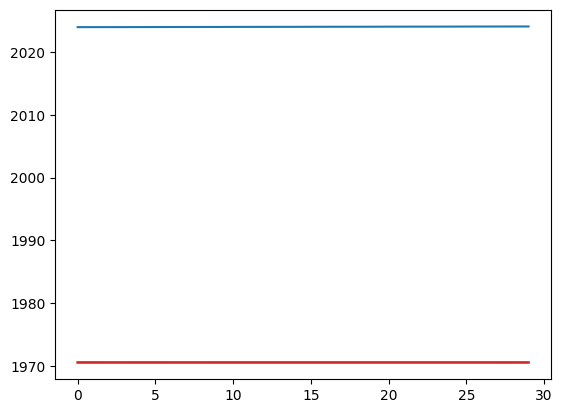